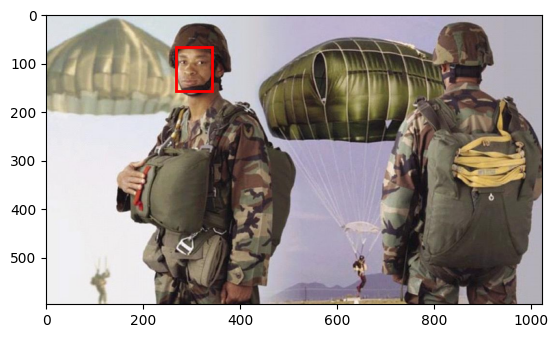

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_bboxes(image_path, bboxes):
    """
    Plots an image with bounding boxes.

    Parameters:
    image_path (str): The path of the image file.
    bboxes (list of lists): A list of bounding boxes, each box is a list of [x, y, width, height].
    """
    # Charger l'image
    img = Image.open(image_path)

    # Créer une figure matplotlib et un axe
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Dessiner chaque bounding box
    for bbox in bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

plot_image_with_bboxes('../data/images/48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_781.jpg', [[268,66,74,90]])

[[67.0, 28.301507537688444, 18.5, 38.59296482412061]]


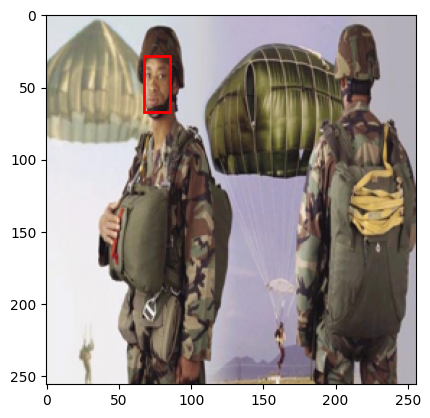

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


def resize_and_plot_bboxes(image_path, bboxes):
    """
    Resize an image to 256x256 and plot it with resized bounding boxes.

    Parameters:
    image_path (str): The path of the image file.
    bboxes (list of lists): A list of bounding boxes, each box is a list of [x, y, width, height].
    """
    # Charger et redimensionner l'image
    img = Image.open(image_path)
    original_size = img.size
    img_resized = img.resize((256, 256))

    # Calculer les facteurs de mise à l'échelle
    scale_x = 256 / original_size[0]
    scale_y = 256 / original_size[1]

    # Ajuster les bounding boxes
    resized_bboxes = []
    for bbox in bboxes:
        x, y, width, height = bbox
        new_x = x * scale_x
        new_y = y * scale_y
        new_width = width * scale_x
        new_height = height * scale_y
        resized_bboxes.append([new_x, new_y, new_width, new_height])

    print(resized_bboxes)

    # Afficher l'image et les bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(img_resized)

    for bbox in resized_bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

resize_and_plot_bboxes('../data/images/48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_781.jpg', [[268,66,74,90]])


In [47]:
##PARAMS

BBOX_PREDICTED = 50
BATCH_SIZE = 16

In [48]:
import numpy as np

import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def preprocess_image_bbox(image_path, bboxes, fixed_bbox_count=50):
    # Load and resize the image
    img = Image.open(image_path)
    original_size = img.size
    img_resized = img.resize((256, 256))

    # Calculate scaling factors
    scale_x = 256 / original_size[0]
    scale_y = 256 / original_size[1]

    # Convert bboxes to numpy array for vectorized operations
    bbox_array = np.array(bboxes)
    scale_array = np.array([scale_x, scale_y, scale_x, scale_y])

    # Resize bounding boxes
    resized_bbox_array = bbox_array * scale_array

    # Padding or truncating the list of bounding boxes to fixed_bbox_count
    current_count = len(resized_bbox_array)
    if current_count < fixed_bbox_count:
        # If less, pad with zeros
        padding = np.zeros((fixed_bbox_count - current_count, 4))
        resized_bbox_array = np.vstack((resized_bbox_array, padding))
    elif current_count > fixed_bbox_count:
        # If more, truncate the array
        resized_bbox_array = resized_bbox_array[:fixed_bbox_count, :]

    # Convert the image to a numpy array
    img_array = np.asarray(img_resized, dtype=np.float32)

    # Convert the numpy array to a PyTorch tensor
    img_tensor = torch.from_numpy(img_array)

    # Reshape and normalize the tensor
    #dd a dimension for channels and reorder dimensions to CxHxW
    img_tensor = img_tensor.permute(2, 0, 1)
    
    # Normalize the tensor 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_tensor_normalized = normalize(img_tensor / 255.)

    # Convert the bounding boxes to a PyTorch tensor
    bbox_tensor = torch.from_numpy(resized_bbox_array).float()

    return img_tensor_normalized, bbox_tensor

img_tensor, bbox_tensor = preprocess_image_bbox('../data/images/48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_781.jpg', [[268,66,74,90]])

print(img_tensor.shape)
print(bbox_tensor.shape)

torch.Size([3, 256, 256])
torch.Size([50, 4])


In [49]:
import os

def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    images = []
    bbox_data = []
    current_bboxes = []

    for line in lines:
        line = line.strip()
        if line.endswith('.jpg'):
            if current_bboxes:
                images.append(current_image)
                bbox_data.append(current_bboxes)
                current_bboxes = []
            current_image = line
        elif line.isdigit():
            continue
        else:
            bbox = list(map(int, line.split()[:4]))  
            current_bboxes.append(bbox)

    if current_bboxes:
        images.append(current_image)
        bbox_data.append(current_bboxes)

    return images, bbox_data

images, bbox_data = load_data('../data/bounding_boxes/wider_faceseglite_bbx.txt')

In [50]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, bbox_data, root_dir, transform=None):
        self.images = images
        self.bbox_data = bbox_data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image, bboxes = preprocess_image_bbox(img_name, self.bbox_data[idx], fixed_bbox_count=BBOX_PREDICTED)
        sample = {'image': image, 'bboxes': bboxes}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [51]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_bbox_data, test_bbox_data = train_test_split(images, bbox_data, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_images, train_bbox_data, '../data/images', transform=None)
test_dataset = CustomDataset(test_images, test_bbox_data, '../data/images', transform=None)

In [52]:
print(len(train_images))
print(len(test_images))

12883
3221


In [53]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, BBOX_PREDICTED * 4)  # Output 50 bounding boxes, each with 4 coordinates

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 32 * 32)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, BBOX_PREDICTED, 4)  # Reshape to have the required output shape

model = SimpleCNN()


In [54]:
def bbox_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters
    ----------
    box1 : list or tensor
        (x1, y1, x2, y2)
    box2 : list or tensor
        (x1, y1, x2, y2)
    
    Returns
    -------
    float
        in [0, 1]
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the union area
    union_area = box1_area + box2_area - intersection_area

    # Compute the IoU
    iou = intersection_area / union_area
    return iou

def iou_loss1(pred_boxes, target_boxes, batch_size):
    """
    Calculate the IoU-based loss given predicted and target bounding boxes.
    """
    loss = 0.0
    for i in range(batch_size):
        for pred_box, target_box in zip(pred_boxes[i], target_boxes[i]):
            loss += 1 - bbox_iou(pred_box, target_box)  # Loss is high when IoU is low, and vice versa
    return loss / batch_size  # Average over all examples in the batch

def iou_loss2(pred_boxes, target_boxes):
    """
    Calculate the IoU-based loss given predicted and target bounding boxes.
    For each predicted box, only consider the target box with the highest IoU.
    """
    loss = 0.0
    for pred_box in pred_boxes:
        # Find the target box with the highest IoU for this predicted box
        highest_iou = max(bbox_iou(pred_box, target_box) for target_box in target_boxes)
        loss += 1 - highest_iou  # Loss is high when IoU is low, and vice versa
    return loss / len(pred_boxes)  # Average over all predicted boxes


In [56]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 1  # Define the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), 0):
        # Get the inputs; data is a dict of [inputs, labels]
        inputs, labels = data['image'], data['bboxes']

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss cross entropy loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print(f'[{epoch + 1}, {i + 1} / {len(train_images) / 4}] loss: {running_loss / 100}')


print('Finished Training')


[1, 1 / 3220.75] loss: 51.253369140625
[1, 101 / 3220.75] loss: 2121.1779443359374
[1, 201 / 3220.75] loss: 3902.677255859375
[1, 301 / 3220.75] loss: 5593.557098999024
[1, 401 / 3220.75] loss: 7338.2086737060545
[1, 501 / 3220.75] loss: 9012.171590576172
[1, 601 / 3220.75] loss: 10745.074710083009
[1, 701 / 3220.75] loss: 12447.367860107423
[1, 801 / 3220.75] loss: 14136.635557861327
Finished Training


In [ ]:
#save the model
torch.save(model.state_dict(), '../models/img_to_bbox_v1.pth')

In [ ]:
#load the model

model = SimpleCNN()
model.load_state_dict(torch.load('../models/img_to_bbox_v1.pth'))

<All keys matched successfully>